In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import requests
import seaborn as sns
# sns.set_style('whitegrid')

# BGA used to set end dates
import datetime

import covid19

## data

In [3]:
# date_italy_regions_path = 'dpc-covid19-ita-regioni.csv'
date_italy_regions_path = covid19.data.download('regioni')


In [4]:
data_italy_regions = pd.read_csv(date_italy_regions_path, parse_dates=['data'], index_col=['data'])
data_italy_regions['totale_terapia_intensiva'] = data_italy_regions['terapia_intensiva'] + data_italy_regions['deceduti']
data_italy_regions['totale_ricoverati'] = data_italy_regions['ricoverati_con_sintomi'] + data_italy_regions['totale_terapia_intensiva']

data_italy_regions.index = data_italy_regions.index.normalize()

print(sorted(data_italy_regions['denominazione_regione'].unique().tolist()))

data_italy_regions.loc[data_italy_regions.index.max()].sort_values('ricoverati_con_sintomi', ascending=False)[['denominazione_regione', 'ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti']]


['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia Romagna', 'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche', 'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana', 'Umbria', "Valle d'Aosta", 'Veneto']


,denominazione_regione,ricoverati_con_sintomi,terapia_intensiva,deceduti
data,,,,
2020-03-19,Lombardia,7387,1006,2168
2020-03-19,Piemonte,2279,257,175
2020-03-19,Emilia Romagna,1900,260,531
2020-03-19,Veneto,771,209,115
2020-03-19,Marche,656,141,115
2020-03-19,Toscana,501,178,38
2020-03-19,Liguria,491,112,91
2020-03-19,Lazio,426,45,38
2020-03-19,Campania,213,36,17


## situation report

In [5]:
DAY = np.timedelta64(24 * 60 * 60,'s')

START_FIT = None
CHANGE_FIT_1 = np.datetime64('2020-03-06')
CHANGE_FIT_2 = np.datetime64('2020-03-15')
STOP_FIT = None

# BGA changed to end today
# EXTRAPOLTATE = ('2020-02-23', '2020-03-19')
EXTRAPOLTATE = ('2020-02-23', datetime.datetime.now().strftime("%Y-%m-%d"))
# print(EXTRAPOLTATE)

# BGA added to ease what to show
SHOW = ['ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti' ]

# BGA changed to match the column names, makes easier to have different fits
REGIONS_FIT_PARAMS = {
    'Lombardia': {
        'ricoverati_con_sintomi': [(None, '2020-03-05'), ('2020-03-06', '2020-03-11'), ('2020-03-12', None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-16')],
        'deceduti': [('2020-02-23', '2020-03-16')]
    },
    'Emilia Romagna': {
        'ricoverati_con_sintomi': [(None, '2020-03-01'), ('2020-03-02', '2020-03-05'), ('2020-03-06', None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-16')],
        'deceduti': [('2020-02-23', '2020-03-16')]
    },
    'Veneto': {
        'ricoverati_con_sintomi': [(None, '2020-03-11'), ('2020-03-12', None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-16')],
        'deceduti': [('2020-02-23', '2020-03-16')]
    },
    'Piemonte': {
        'ricoverati_con_sintomi': [(None, '2020-03-08'), ('2020-03-08', None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-16')],
        'deceduti': [('2020-02-23', '2020-03-16')]
    },
    'Marche': {
        'ricoverati_con_sintomi': [(None, '2020-03-05'), ('2020-03-06', '2020-03-14'), ('2020-03-15', None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-13'), ('2020-03-14', None)],
        'deceduti': [('2020-02-23', None)]
    },
    'Toscana': {
        'ricoverati_con_sintomi': [(None, '2020-03-08'), ('2020-03-08', None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-16')],
        'deceduti': [('2020-02-23', '2020-03-16')]
    },
    'Liguria': {
        'ricoverati_con_sintomi': [('2020-03-04', None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-16')],
        'deceduti': [('2020-02-23', '2020-03-16')]
    },
    'Lazio':  {
        'ricoverati_con_sintomi': [(None, '2020-03-09'), ('2020-03-10', '2020-03-13'), ('2020-03-14', None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-16')],
        'deceduti': [('2020-02-23', '2020-03-16')]
    },
    'Campania': {
        'ricoverati_con_sintomi': [('2020-03-07', None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-16')],
        'deceduti': [('2020-02-23', '2020-03-16')]
    },
    'Puglia': {},
    'Abruzzo': {},
    'Basilicata': {},
    'Calabria': {},
    'Friuli Venezia Giulia': {},
    'Molise': {},
    'Sardegna': {},
    'Sicilia': {
        'ricoverati_con_sintomi': [('2020-03-08', None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-16')],
        'deceduti': [('2020-02-23', '2020-03-16')]

    },
    'Umbria': {},
    "Valle d'Aosta": {},
}
    
DELAY = 12 * DAY
PALETTE_ONE = list(sns.color_palette())
PALETTE = itertools.cycle(PALETTE_ONE)

('2020-02-23', '2020-03-20')


In [6]:
fits = {}
for region, params in REGIONS_FIT_PARAMS.items():
    # BGA changed to cycle in SHOW
    for kind in SHOW:
        exponential_fits = params.get(kind, [(START_FIT, CHANGE_FIT_1), (CHANGE_FIT_1 + DAY, CHANGE_FIT_2), (CHANGE_FIT_2 + DAY, STOP_FIT)])
        fits[region, kind] = []
        for start, stop in exponential_fits:
            try:
                select = (data_italy_regions['denominazione_regione'] == region) & (data_italy_regions[kind] >= 8)
                fits[region, kind] += [covid19.fit.ExponentialFit.from_frame(kind, data_italy_regions[select], start=start, stop=stop)]
            except:
                print('skipping:', region, start, stop)

skipping: Puglia None 2020-03-06
skipping: Puglia None 2020-03-06
skipping: Puglia 2020-03-07T00:00:00 2020-03-15
skipping: Puglia None 2020-03-06
skipping: Abruzzo None 2020-03-06
skipping: Abruzzo None 2020-03-06
skipping: Abruzzo 2020-03-07T00:00:00 2020-03-15
skipping: Basilicata None 2020-03-06
skipping: Basilicata 2020-03-07T00:00:00 2020-03-15
skipping: Basilicata None 2020-03-06
skipping: Basilicata 2020-03-07T00:00:00 2020-03-15
skipping: Basilicata 2020-03-16T00:00:00 None
skipping: Basilicata None 2020-03-06
skipping: Basilicata 2020-03-07T00:00:00 2020-03-15
skipping: Basilicata 2020-03-16T00:00:00 None
skipping: Calabria None 2020-03-06
skipping: Calabria None 2020-03-06
skipping: Calabria 2020-03-07T00:00:00 2020-03-15
skipping: Calabria None 2020-03-06
skipping: Calabria 2020-03-07T00:00:00 2020-03-15
skipping: Calabria 2020-03-16T00:00:00 None
skipping: Friuli Venezia Giulia None 2020-03-06
skipping: Friuli Venezia Giulia None 2020-03-06
skipping: Friuli Venezia Giulia 

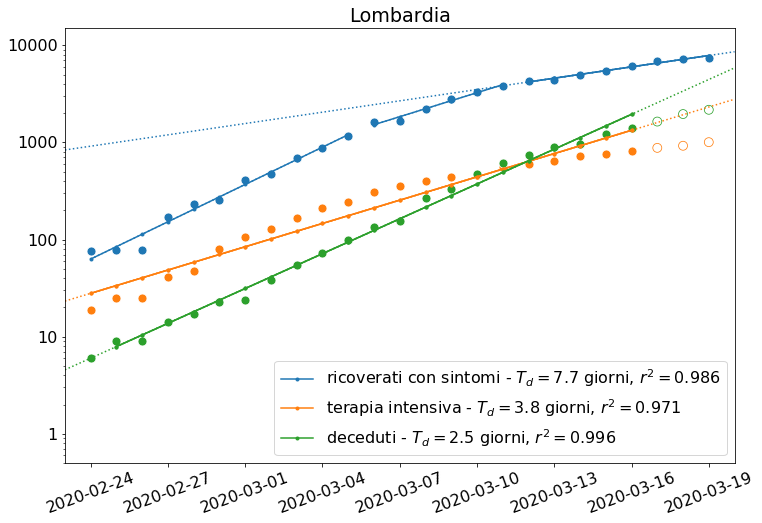

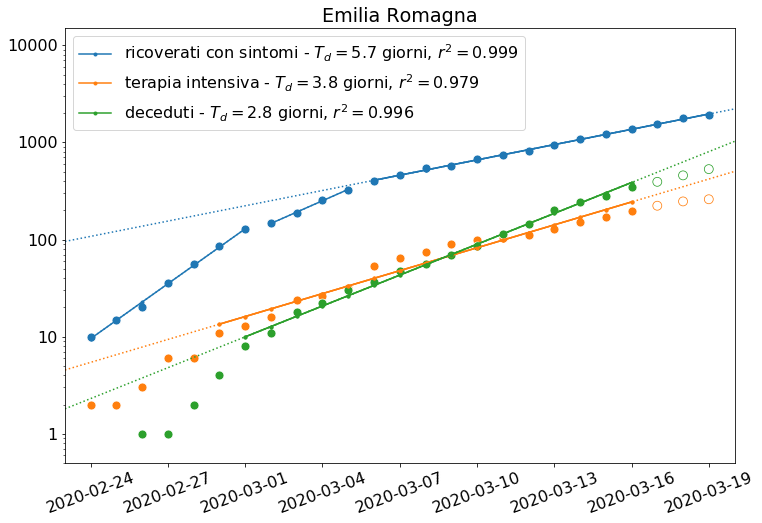

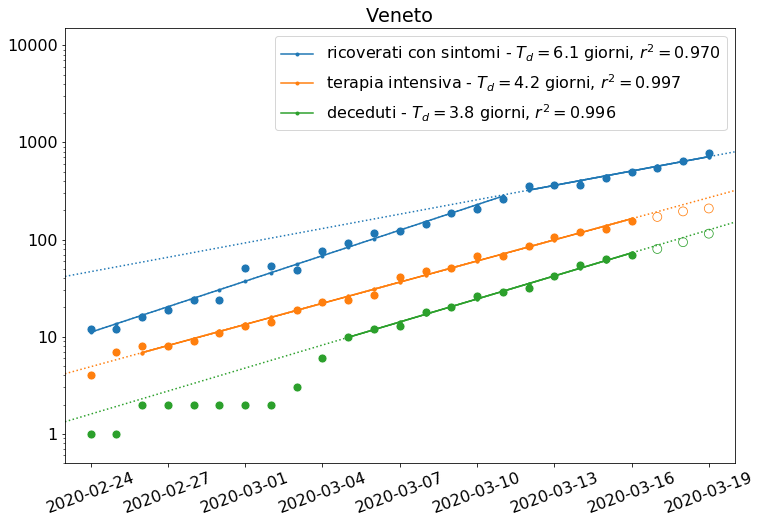

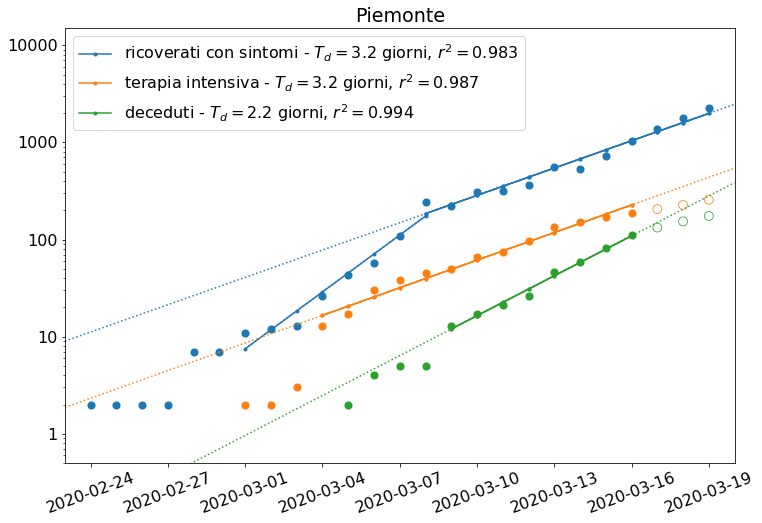

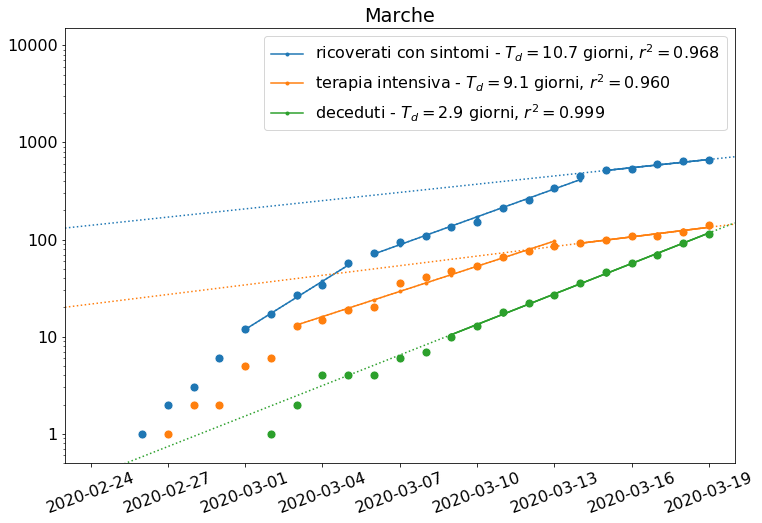

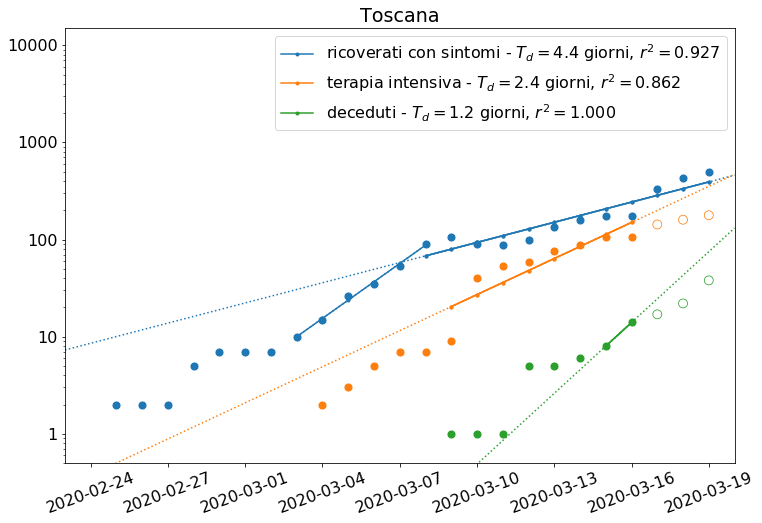

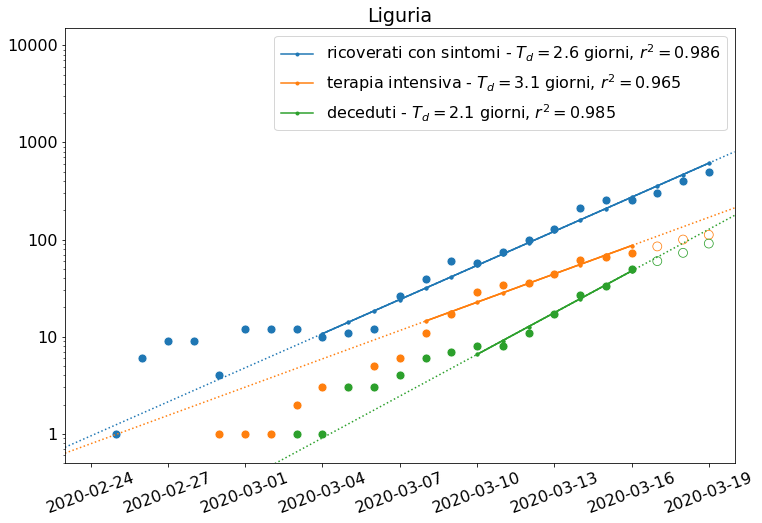

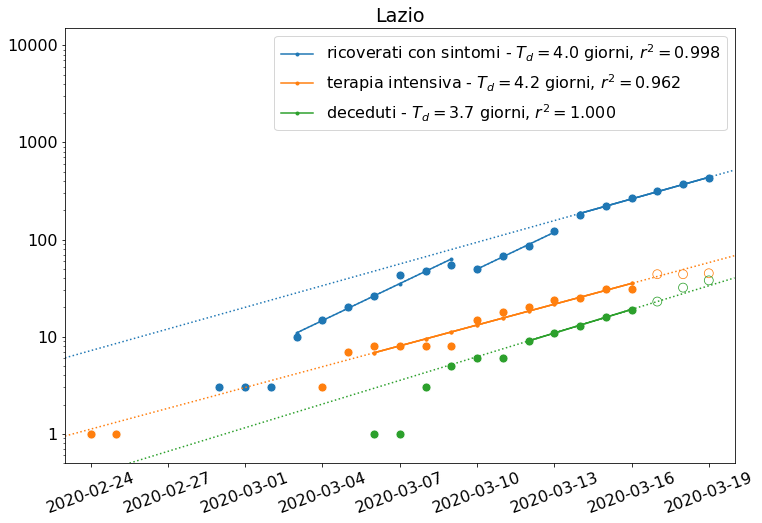

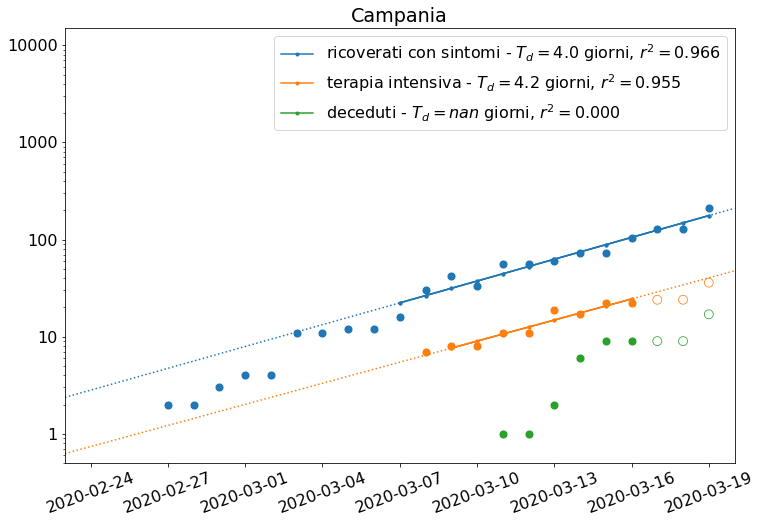

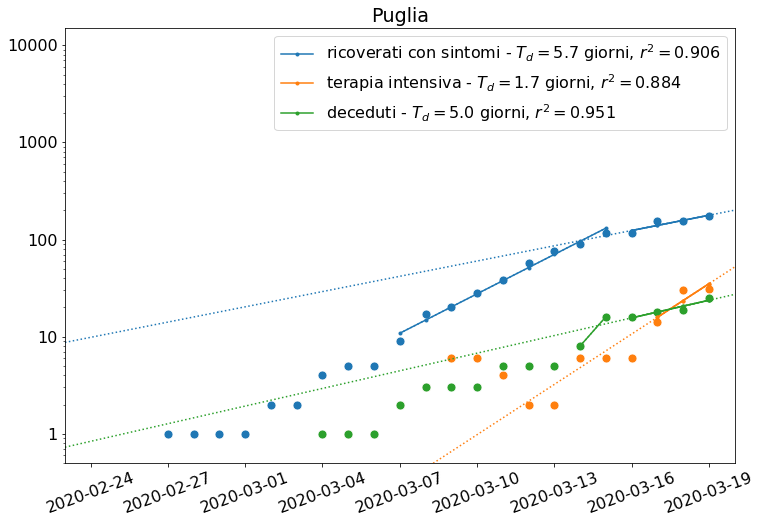

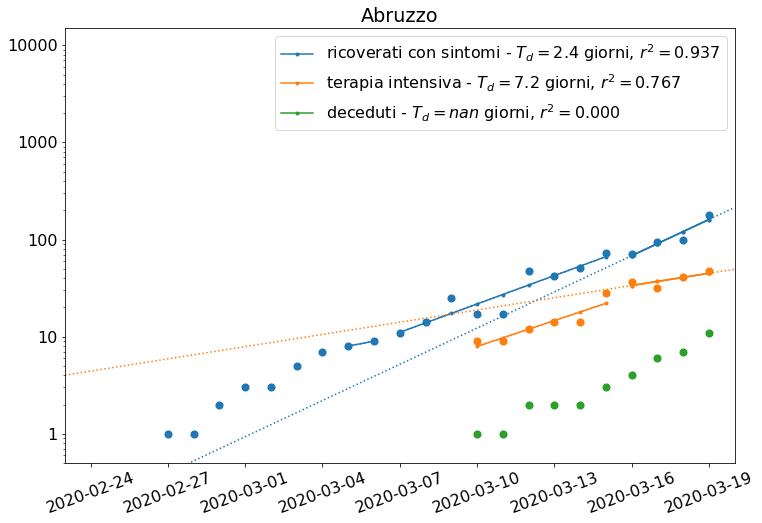

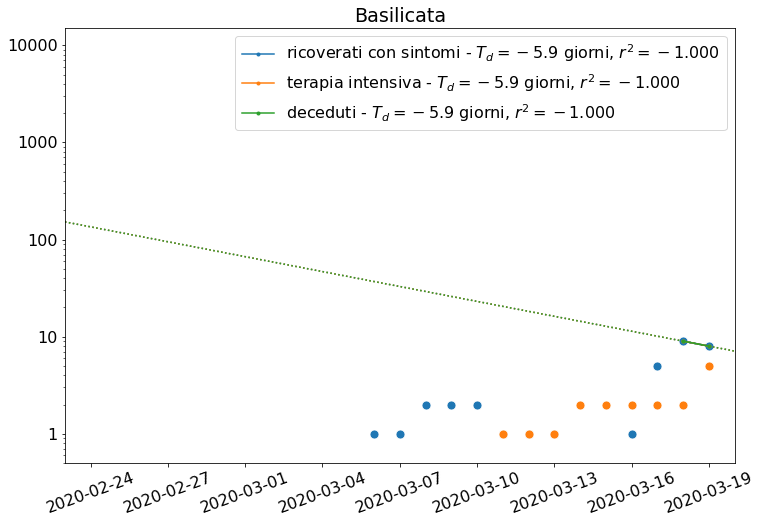

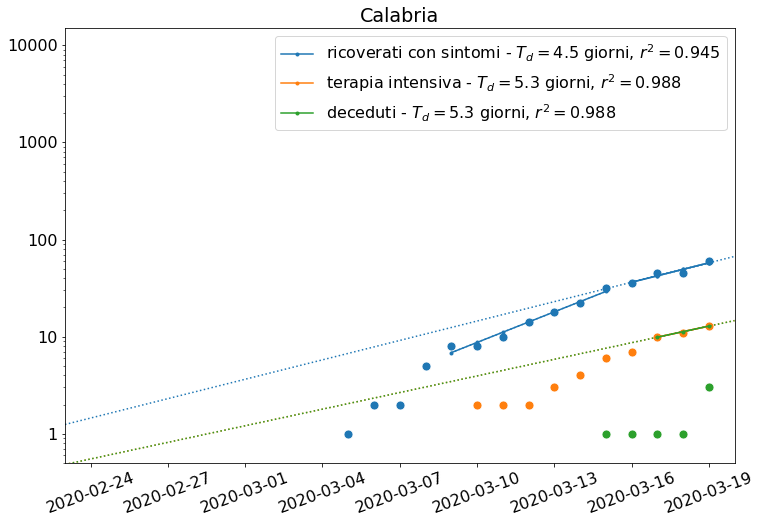

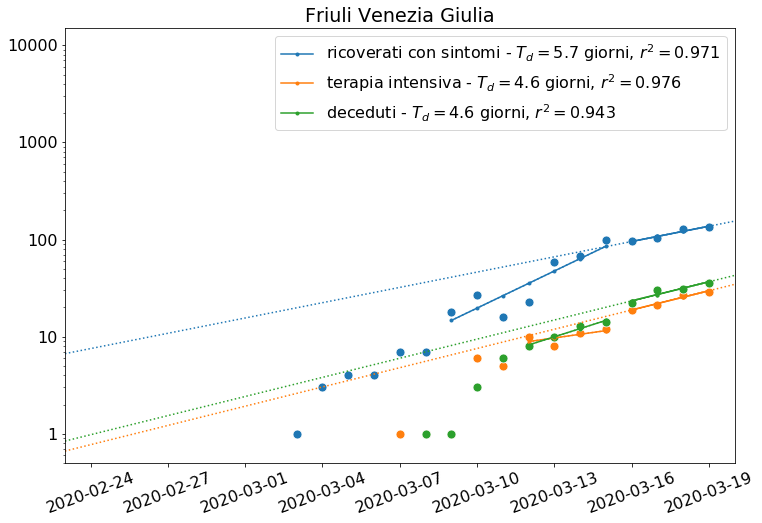

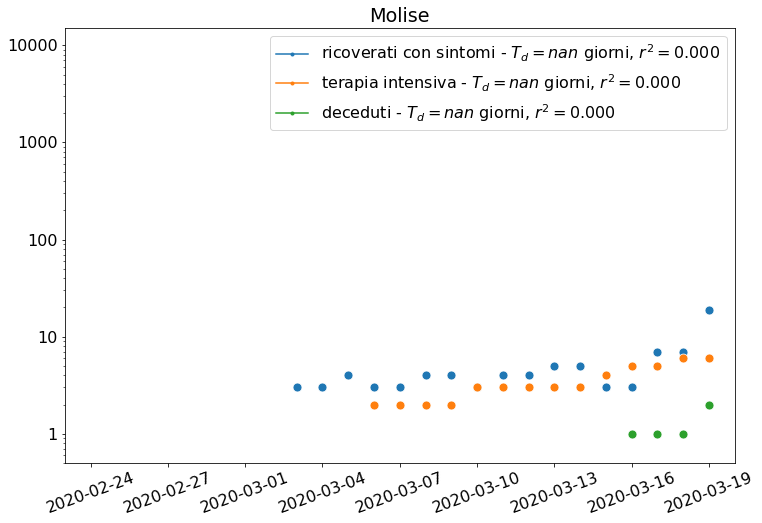

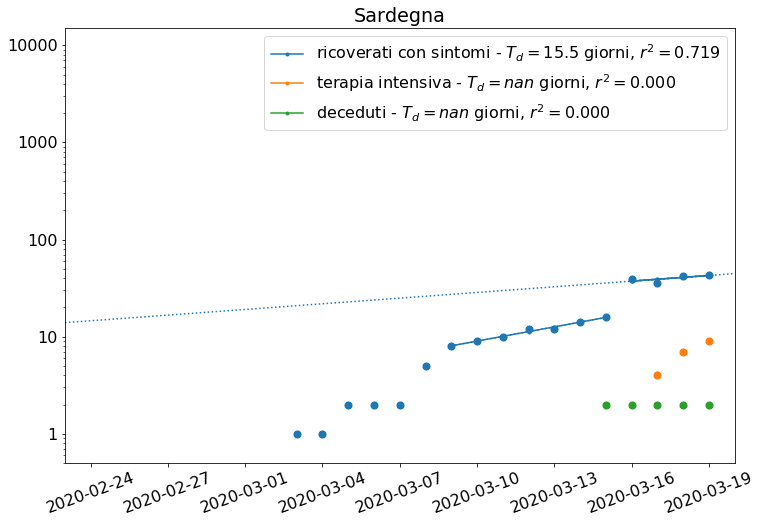

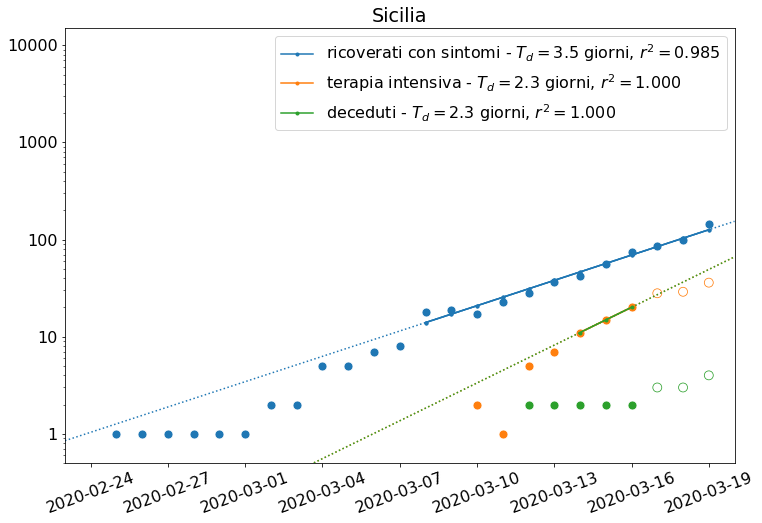

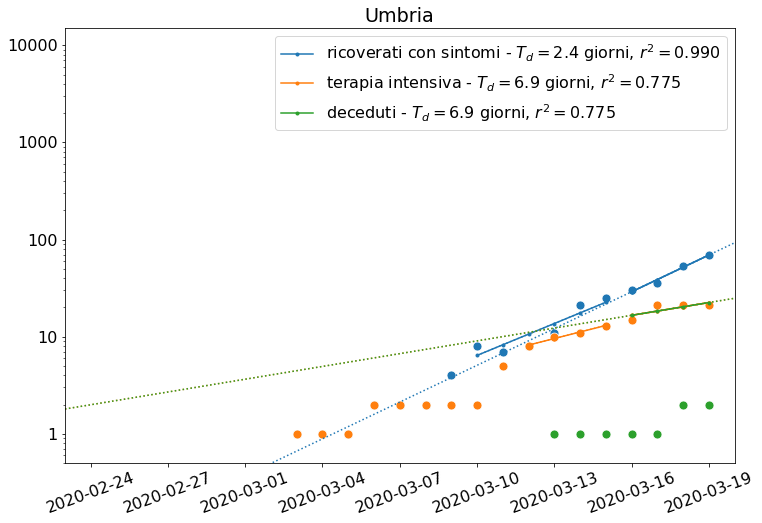

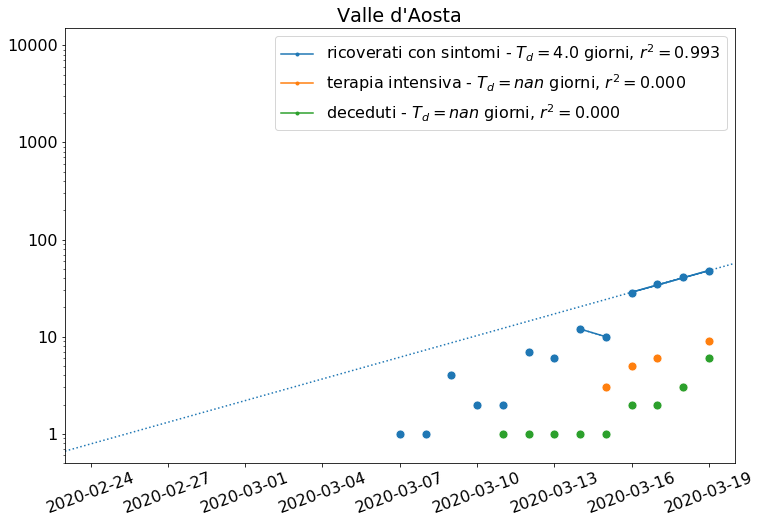

In [7]:
for region in REGIONS_FIT_PARAMS:
    
        # BGA perdonabile porcata 1
        if len(fits[region, 'ricoverati_con_sintomi']) == 0:
            print('No data for', region)
            continue
        _, ax = plt.subplots(subplot_kw={'yscale': 'log', 'ylim': (0.5, 15000)}, figsize=(12, 8))
        # _ = covid19.plot.add_events(ax, linestyle=':', offset=11, color='grey')
        select = (data_italy_regions['denominazione_regione'] == region)
        try:
            # BGA changed to cycle in SHOW
            for kind, color in zip(SHOW, sns.color_palette()):                
                for fit in fits[region, kind]:
                    covid19.plot.plot_fit(ax, fit,  color=color)
                #covid19.plot.plot_data(ax, data_italy_regions[select][kind], fit.start, fit.stop, color=color, date_interval=3)
                covid19.plot.plot(ax, data_italy_regions[select][kind], fit, label=kind.replace('_', ' '), extrapolate=EXTRAPOLTATE, color=color, date_interval=3)
                # covid19.plot.plot(ax, data_italy_regions[select][kind], fit, label=kind.replace('_', ' '), extrapolate=EXTRAPOLTATE, color=sns.color_palette()[0], date_interval=3)
            
            ax.set_title(region)
        except:
            pass

#_ = ax.set(title=r'COVID-19 "severe" cases in Italy. Fit is $f(t) = 2 ^ \frac{t - t_0}{T_d}$, with $T_d$ doubling time and $t_0$ reference date')


## Estimate of the initial / uncontined doubling time

In [8]:
for key, value in list(fits.items())[:10]:
    if len(value):
        print(f'{key[0]}:{" " * (14 - len(key[0]))} {str(value[0])}')

Lombardia:      T_d=2.35, t_0='2020-02-09', r^2=0.988 start='2020-02-24', stop='2020-03-05'
Lombardia:      T_d=3.77, t_0='2020-02-05', r^2=0.971 start='2020-02-24', stop='2020-03-16'
Lombardia:      T_d=2.52, t_0='2020-02-17', r^2=0.996 start='2020-02-25', stop='2020-03-16'
Emilia Romagna: T_d=1.60, t_0='2020-02-18', r^2=0.998 start='2020-02-24', stop='2020-03-01'
Emilia Romagna: T_d=3.83, t_0='2020-02-14', r^2=0.979 start='2020-02-29', stop='2020-03-16'
Emilia Romagna: T_d=2.84, t_0='2020-02-20', r^2=0.996 start='2020-03-01', stop='2020-03-16'
Veneto:         T_d=3.44, t_0='2020-02-12', r^2=0.992 start='2020-02-24', stop='2020-03-11'
Veneto:         T_d=4.15, t_0='2020-02-14', r^2=0.997 start='2020-02-26', stop='2020-03-16'
Veneto:         T_d=3.81, t_0='2020-02-21', r^2=0.996 start='2020-03-05', stop='2020-03-16'
Piemonte:       T_d=1.54, t_0='2020-02-25', r^2=0.975 start='2020-03-01', stop='2020-03-08'


In [9]:
for key, value in list(fits.items())[:10]:
    if len(value):
        print(f'{key[0]}:{" " * (14 - len(key[0]))} {str(value[-1])}')

Lombardia:      T_d=7.74, t_0='2019-12-09', r^2=0.986 start='2020-03-12', stop='2020-03-19'
Lombardia:      T_d=3.77, t_0='2020-02-05', r^2=0.971 start='2020-02-24', stop='2020-03-16'
Lombardia:      T_d=2.52, t_0='2020-02-17', r^2=0.996 start='2020-02-25', stop='2020-03-16'
Emilia Romagna: T_d=5.74, t_0='2020-01-16', r^2=0.999 start='2020-03-06', stop='2020-03-19'
Emilia Romagna: T_d=3.83, t_0='2020-02-14', r^2=0.979 start='2020-02-29', stop='2020-03-16'
Emilia Romagna: T_d=2.84, t_0='2020-02-20', r^2=0.996 start='2020-03-01', stop='2020-03-16'
Veneto:         T_d=6.10, t_0='2020-01-21', r^2=0.970 start='2020-03-12', stop='2020-03-19'
Veneto:         T_d=4.15, t_0='2020-02-14', r^2=0.997 start='2020-02-26', stop='2020-03-16'
Veneto:         T_d=3.81, t_0='2020-02-21', r^2=0.996 start='2020-03-05', stop='2020-03-16'
Piemonte:       T_d=3.21, t_0='2020-02-12', r^2=0.983 start='2020-03-08', stop='2020-03-19'
